In [48]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pyod.utils.data import generate_data, get_outliers_inliers

import warnings
warnings.filterwarnings('ignore')

## 샘플 데이터 생성

OCSVM은 Unsupervised Learning Method 중 하나이며, Novelty Detection에서 사용되는 방법 중 하나이다. 

따라서, 모든 데이터를 정상이라고 가정하고 모델 훈련을 수행해야 한다.

샘플 데이터를 생성하는 과정은 다음과 같다.

- PyoD 라이브러리를 사용하여 샘플 데이터 생성. 이 때, 실제 Outlier 비율은 전체 데이터의 5%로 지정한다.


- 전체 데이터에서 훈련 데이터와 테스트 데이터를 분할한다.

In [2]:
train, test = generate_data(random_state = 42, train_only = True, contamination = 0.05)
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size = 0.2, random_state = 42)

## 모델 적합

앞서 말했듯이, OCSVM은 라벨 데이터를 필요로하지 않는다. 따라서, 피쳐 데이터만을 이용해 모델을 적합시킨다.

In [3]:
clf = svm.OneClassSVM(nu = 0.1, kernel = 'rbf', gamma = 0.1)
clf.fit(X_train) # Unsupervised Learning Method

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
            max_iter=-1, nu=0.1, shrinking=True, tol=0.001, verbose=False)

## 적합 모델을 이용한 라벨 분류

In [220]:
class OCSVM:
    def __init__(self, nu, kernel, gamma):
        self.nu = nu
        self.kernel = kernel
        self.gamma = gamma
        self.result_df = pd.DataFrame()
        
        self.clf = svm.OneClassSVM(nu = self.nu, kernel = self.kernel, gamma = self.gamma)
        
    def fit(self, X_train, ground_truth):
        self.X_train = X_train
        self.y_train = ground_truth
        
        self.clf.fit(self.X_train)
        
        return self.clf
    
    def predict(self, X_test, is_return = False):
        self.X_test = X_test
        
        self.prediction = self.clf.predict(self.X_test)
        
        if is_return:
            
            return self.prediction
    
    def visualization(self):
        self.result_df['X1'] = self.X_train[:, 0]
        self.result_df['X2'] = self.X_train[:, 1]
        self.result_df['Prediction'] = pd.Series(self.prediction).apply(lambda x: 0 if x == 1 else 1)
        self.result_df['Actual'] = self.y_train
        
        xx, yy = np.meshgrid(np.linspace(self.result_df['X1'].min() - 1, self.result_df['X1'].max() + 1, 500),
                            np.linspace(self.result_df['X2'].min() - 1, self.result_df['X2'].max() + 1, 500))
        
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        z = z.reshape(xx.shape)
        
        plt.title("Novelty Detection\nNu = {}, Kernel = {}, Gamma = {}".format(self.nu, self.kernel, self.gamma))
        plt.contourf(xx, yy, levels = np.linspace(z.min(), 0, 7), cmap = plt.cm.PuBu)
        a = plt.contourf(xx, yy, z, level = [0], linewidths = 2, color = 'darkred')
        plt.contourf(xx, yy, z, levels=[0, z.max()], colors='palevioletred')

        s = 40
        b1 = plt.scatter(self.X_train[:, 0], self.X_train[:, 1], c = 'white', s = s, edgecolors = 'k')
        outlier = plt.scatter(self.result_df.loc[self.result_df['Prediction'] == 1]['X1'], self.result_df.loc[self.result_df['Prediction'] == 1]['X2'],
                             c = 'red', edgecolor = 'k')
        actual = plt.scatter(self.result_df.loc[self.result_df['Actual'] == 1]['X1'], self.result_df.loc[self.result_df['Actual'] == 1]['X2'],
                            c = 'gold', edgecolor = 'k', alpha = 0.8)
        
        plt.axis('tight')
        plt.xlim((self.result_df['X1'].min() - 1, self.result_df['X1'].max() + 1))
        plt.ylim((self.result_df['X2'].min() - 1, self.result_df['X2'].max() + 1))
        
        plt.show()

In [275]:
nu = 0.1
kernel = 'rbf'
gamma = 0.007

model = OCSVM(nu = nu, kernel = kernel, gamma = gamma)
model.fit(X_train, y_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.007, kernel='rbf',
            max_iter=-1, nu=0.1, shrinking=True, tol=0.001, verbose=False)

In [276]:
model.predict(X_train)

## 시각화

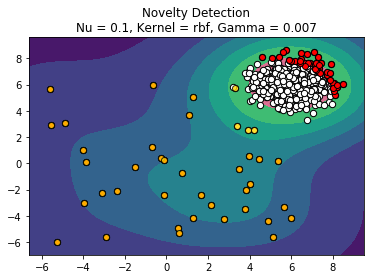

In [277]:
model.visualization()

그래프를 통해 알 수 있다시피, OCSVM 하이퍼파라미터의 Nu는 SVM의 c와 비슷한 의미를 가진다. 다른 의미로 말하면, 오분류 비율에 대한 최대 상한 값이라고 볼 수도 있다. 예를 들어, Nu = 0.05로 설정하면 훈련 데이터의 최대 5%가 잘 못 분류된다고 말할 수 있다.